# ANEXO I: CUADERNO COMPLETO DEL CÓDIGO EN PYTHON

# Carga del conjunto de datos

Extraídos del siguiente enlace desde Kaggle.com https://www.kaggle.com/code/devraai/credit-analysis-default-prediction/input

In [1]:
import pandas as pd
datos_prestamos = pd.read_csv('cr_loan2.csv')
display(datos_prestamos.head())

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# Análisis del conjunto de datos

In [2]:
print(datos_prestamos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB
None


In [3]:
datos_prestamos.shape

(32581, 12)

In [4]:
for column in datos_prestamos.columns:
    print(f"Número de valores únicos en '{column}': {datos_prestamos[column].nunique()}")
    if datos_prestamos[column].nunique() < 10:
        print(f"\tValores únicos en '{column}': {datos_prestamos[column].unique()}\n")

Número de valores únicos en 'person_age': 58
Número de valores únicos en 'person_income': 4295
Número de valores únicos en 'person_home_ownership': 4
	Valores únicos en 'person_home_ownership': ['RENT' 'OWN' 'MORTGAGE' 'OTHER']

Número de valores únicos en 'person_emp_length': 36
Número de valores únicos en 'loan_intent': 6
	Valores únicos en 'loan_intent': ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']

Número de valores únicos en 'loan_grade': 7
	Valores únicos en 'loan_grade': ['D' 'B' 'C' 'A' 'E' 'F' 'G']

Número de valores únicos en 'loan_amnt': 753
Número de valores únicos en 'loan_int_rate': 348
Número de valores únicos en 'loan_status': 2
	Valores únicos en 'loan_status': [1 0]

Número de valores únicos en 'loan_percent_income': 77
Número de valores únicos en 'cb_person_default_on_file': 2
	Valores únicos en 'cb_person_default_on_file': ['Y' 'N']

Número de valores únicos en 'cb_person_cred_hist_length': 29


## Análisis y corrección de valores nulos

In [5]:
datos_prestamos.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Hay valores nulos en las variables `person_emp_length` y `loan_int_rate`, es decir, en las variables de "cantidad de años trabajando de la persona solicitante del préstamo" y "tipo de interés del préstamo". 


Al ser ambas variables numéricas, se rellenan los valores nulos con la mediana de cada variable correspondiente, para evitar que el valor se vea afectado por valores extremos.

In [6]:
person_emp_length_median = datos_prestamos['person_emp_length'].median()
loan_int_rate_median = datos_prestamos['loan_int_rate'].median()

print(f'Mediana de person_emp_length: {person_emp_length_median}',
      f'\nMediana de loan_int_rate: {loan_int_rate_median}')

datos_prestamos['person_emp_length'] = datos_prestamos['person_emp_length'].fillna(person_emp_length_median)
datos_prestamos['loan_int_rate'] = datos_prestamos['loan_int_rate'].fillna(loan_int_rate_median)

Mediana de person_emp_length: 4.0 
Mediana de loan_int_rate: 10.99


## Análisis y corrección de variables numéricas

### Análisis de correlación

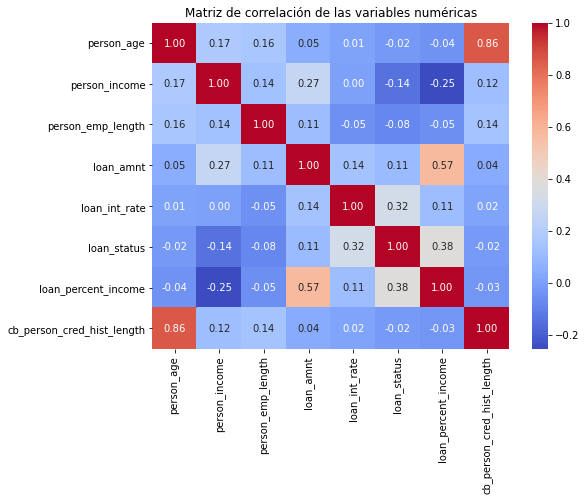

In [7]:
# Selección de variables numéricas para el análisis de correlación
datos_prestamos_num = datos_prestamos.select_dtypes(include=['number'])

# Cálculo de la matriz de correlación entre todas las variables numéricas
correlation = datos_prestamos_num.corr()

# Visualización de la matriz de correlación utilizando un mapa de calor
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de correlación de las variables numéricas')
plt.show()

### Análisis de distribución

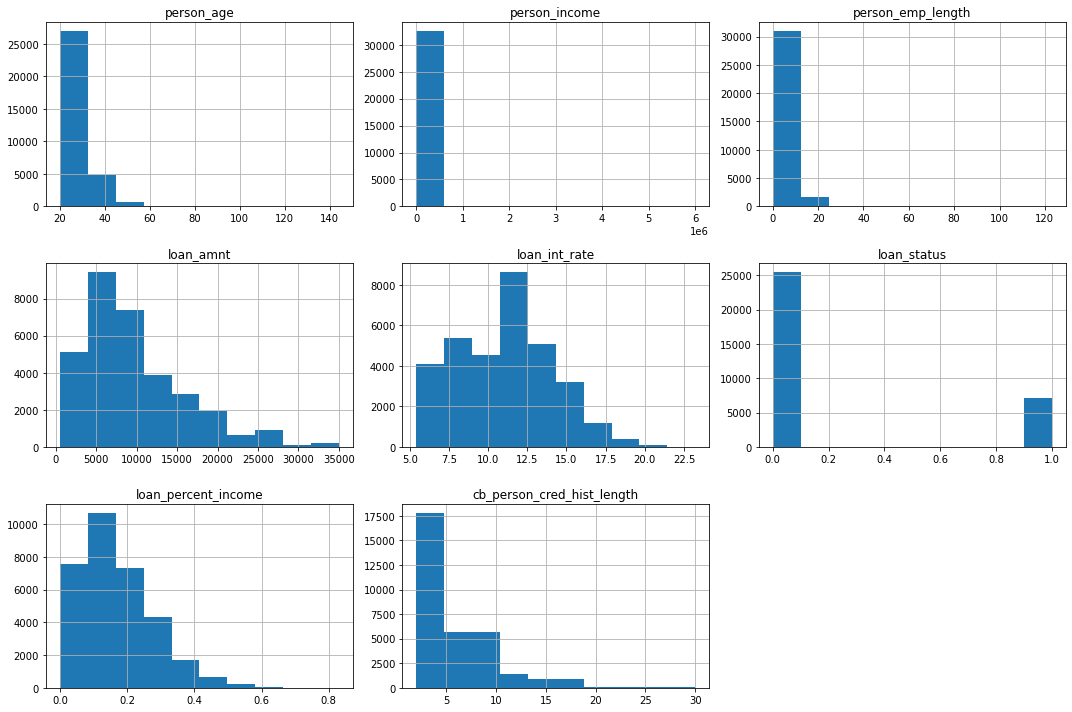

In [8]:
datos_prestamos.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

Se ven valores extremos poco lógicos en las variables de `person_age` y `person_emp_length`; las personas no suelen vivir más de 100 años ni trabajar más de 50. 

Las observaciones afectadas son muy pocas, por lo que se excluyen del conjunto de datos.

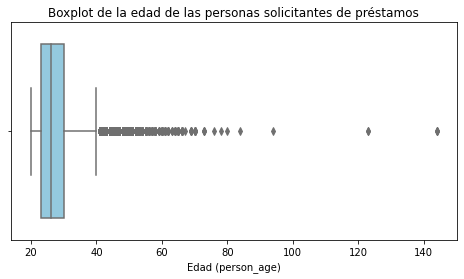

In [9]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=datos_prestamos['person_age'], color='skyblue')
plt.title('Boxplot de la edad de las personas solicitantes de préstamos')
plt.xlabel('Edad (person_age)')
plt.show()

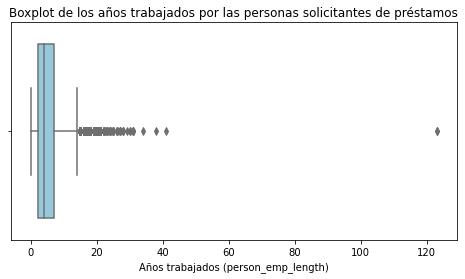

In [10]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=datos_prestamos['person_emp_length'], color='skyblue')
plt.title('Boxplot de los años trabajados por las personas solicitantes de préstamos')
plt.xlabel('Años trabajados (person_emp_length)')
plt.show()

In [11]:
datos_prestamos = datos_prestamos[datos_prestamos['person_emp_length'] <= 50]

La variable `loan_income` tiene una distribución muy claramente sesgada hacia la derecha debido a los valores extremos de millones mientras que la mediana está muy alejada. Sin embargo, los valores extremos son verosímiles; puede ser que una persona cobre ~2.000.000€ netos anuales, y no sería correcto eliminarlos.

Es necesario evitar que los valores extremos no dominen las predicciones del modelo. Para ello, es necesario realizar una transformación logarítmica a la variable, consiguiendo así una distribución normalizada. 

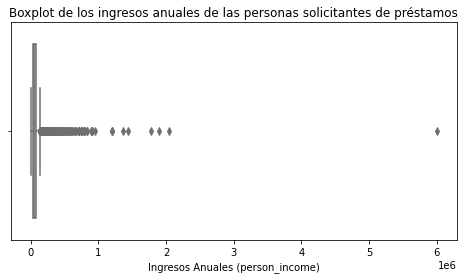

In [12]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=datos_prestamos['person_income'], color='skyblue')
plt.title('Boxplot de los ingresos anuales de las personas solicitantes de préstamos')
plt.xlabel('Ingresos Anuales (person_income)')
plt.show()

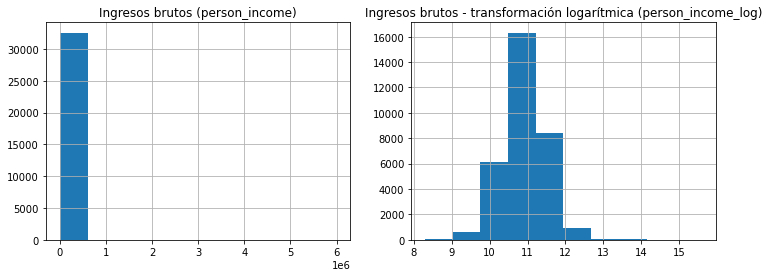

In [13]:
import numpy as np

datos_prestamos['person_income_log'] = np.log1p(datos_prestamos['person_income'])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
datos_prestamos['person_income'].hist(ax=ax[0])
ax[0].set_title('Ingresos brutos (person_income)')
datos_prestamos['person_income_log'].hist(ax=ax[1])
ax[1].set_title('Ingresos brutos - transformación logarítmica (person_income_log)')

plt.show()


En la variable `loan_percent_income` se observan valores interesantes; casos de personas que dedican más de la mitad de sus ingresos a pagar el préstamo. Al estudiar en mayor profundidad estos casos, se identifica que el 78% de ellos generaron impagos. Esta conclusión tiene mucho sentido económico, por lo que esta variable posiblemente sea muy buen indicador de la variable de *default* (`loan_status`).

In [14]:
default_lpi_bt_50 = datos_prestamos[datos_prestamos['loan_percent_income'] > 0.5]['loan_status'].mean()
print(f'Proporción de impagos cuando el porcentaje de ingresos dedicados al préstamo es mayor al 50%: {default_lpi_bt_50:.2%}')

Proporción de impagos cuando el porcentaje de ingresos dedicados al préstamo es mayor al 50%: 78.54%


El resultado final de este análisis de distribuciones es el siguiente.

In [15]:
datos_prestamos = datos_prestamos.drop(columns = ['person_income'])
datos_prestamos.columns

Index(['person_age', 'person_home_ownership', 'person_emp_length',
       'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate',
       'loan_status', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'person_income_log'],
      dtype='object')

## Análisis y corrección de variables categóricas

Variables categóricas:
1. **Tipo de vivienda del solicitante del préstamo**: *home ownership*; si alquila la vivienda en la que vive, si está pagando una hipoteca, si es suya, u otro, por ejemplo, si vive en casa de sus familiares, amigos, etc.
2. **Razón de la solicitud del préstamo**: *loan intent*; a qué se va a destinar el dinero prestado, a pagar un tratamiento médico, estudios académicos, pagar una vivienda (hipoteca), renovar una vivienda, o saldar alguna otra deuda preexistente.

No existe un orden numérico asociado a los valores de estas variables categóricas, por lo que se utiliza la técnica de *One-Hot-Encoding*, es decir, crear una variable por cada valor de "tipo de vivienda" y cada valor de "razón de solicitud del préstamo". En las observaciones donde la persona solicitante esté pagando un alquiler de vivienda y pida un préstamo para realizar unos estudios de máster, todas las variables tomarán valor 0, excepto las que indiquen el que el tipo de vivienda es de `alquiler`, y que el préstamo será destinado a `estudios académicos`, que tomarán valor 1.

In [16]:
display(datos_prestamos['person_home_ownership'].value_counts())

RENT        16445
MORTGAGE    13443
OWN          2584
OTHER         107
Name: person_home_ownership, dtype: int64

In [17]:
datos_prestamos['home_ownership_rent'] = (datos_prestamos['person_home_ownership']=='RENT').astype(int)
datos_prestamos['home_ownership_mortgage'] = (datos_prestamos['person_home_ownership']=='MORTGAGE').astype(int)
datos_prestamos['home_ownership_own'] = (datos_prestamos['person_home_ownership']=='OWN').astype(int)
datos_prestamos['home_ownership_other'] = (datos_prestamos['person_home_ownership']=='OTHER').astype(int)
display(datos_prestamos[['person_home_ownership', 'home_ownership_rent', 'home_ownership_mortgage', 'home_ownership_own', 'home_ownership_other']].head())

,person_home_ownership,home_ownership_rent,home_ownership_mortgage,home_ownership_own,home_ownership_other
1,OWN,0,0,1,0
2,MORTGAGE,0,1,0,0
3,RENT,1,0,0,0
4,RENT,1,0,0,0
5,OWN,0,0,1,0


In [18]:
display(datos_prestamos['loan_intent'].value_counts())

EDUCATION            6453
MEDICAL              6071
VENTURE              5718
PERSONAL             5520
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: loan_intent, dtype: int64

In [19]:
datos_prestamos['loan_intent_education'] = (datos_prestamos['loan_intent']=='EDUCATION').astype(int)  
datos_prestamos['loan_intent_medical'] = (datos_prestamos['loan_intent']=='MEDICAL').astype(int)
datos_prestamos['loan_intent_venture'] = (datos_prestamos['loan_intent']=='VENTURE').astype(int)
datos_prestamos['loan_intent_personal'] = (datos_prestamos['loan_intent']=='PERSONAL').astype(int)
datos_prestamos['loan_intent_debt'] = (datos_prestamos['loan_intent']=='DEBTCONSOLIDATION').astype(int)
datos_prestamos['loan_intent_home'] = (datos_prestamos['loan_intent']=='HOMEIMPROVEMENT').astype(int)

display(datos_prestamos[['loan_intent', 'loan_intent_education', 'loan_intent_medical', 'loan_intent_venture', 'loan_intent_personal', 'loan_intent_debt', 'loan_intent_home']].head())

,loan_intent,loan_intent_education,loan_intent_medical,loan_intent_venture,loan_intent_personal,loan_intent_debt,loan_intent_home
1,EDUCATION,1,0,0,0,0,0
2,MEDICAL,0,1,0,0,0,0
3,MEDICAL,0,1,0,0,0,0
4,MEDICAL,0,1,0,0,0,0
5,VENTURE,0,0,1,0,0,0


In [20]:
# Eliminación de las columnas originales categóricas ya codificadas
datos_prestamos = datos_prestamos.drop(columns = ['person_home_ownership', 'loan_intent'])
display(datos_prestamos.head())

,person_age,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_income_log,home_ownership_rent,home_ownership_mortgage,home_ownership_own,home_ownership_other,loan_intent_education,loan_intent_medical,loan_intent_venture,loan_intent_personal,loan_intent_debt,loan_intent_home
1,21,5.0,B,1000,11.14,0,0.10,N,2,9.169623,0,0,1,0,1,0,0,0,0,0
2,25,1.0,C,5500,12.87,1,0.57,N,3,9.169623,0,1,0,0,0,1,0,0,0,0
3,23,4.0,C,35000,15.23,1,0.53,N,2,11.089821,1,0,0,0,0,1,0,0,0,0
4,24,8.0,C,35000,14.27,1,0.55,Y,4,10.904138,1,0,0,0,0,1,0,0,0,0
5,21,2.0,A,2500,7.14,1,0.25,N,2,9.200391,0,0,1,0,0,0,1,0,0,0



3. **Grado de riesgo del préstamo**: *loan grade*; indica el riesgo asociado a un préstamo, toma valores de la A a la G, correspondiendo A con un riesgo muy bajo y G con el nivel de riesgo más alto.

Esta última variable sí que conlleva un orden implícito, por lo que se puede codificar con valores de 1 a 7, siendo 1 el valor correspondiente con A y 7 el valor asociado a préstamos con calificación G de nivel de riesgo.

In [21]:
display(datos_prestamos['loan_grade'].value_counts())

A    10776
B    10451
C     6458
D     3625
E      964
F      241
G       64
Name: loan_grade, dtype: int64

In [22]:
valores =  ['A', 'B', 'C', 'D', 'E', 'F', 'G']
labels = []

for i in datos_prestamos['loan_grade']:
    if i in valores:
        labels.append(valores.index(i)+1)

datos_prestamos['loan_grade'] = labels

print(f"Valores únicos en '{'loan_grade'}': {datos_prestamos['loan_grade'].unique()}")

Valores únicos en 'loan_grade': [2 3 1 4 5 6 7]


4. **Indicador de previas situaciones de impago asociadas a la persona solicitante del préstamo**; *person default on file*, toma valor 'Y' para indicar que sí existieron situaciones de impago en el histórico y 'N' para indicar lo contrario.

En este caso la codificación de esta variable categórica es muy simple, ya que es una variable booleana (Sí o No; Verdadero o Falso; True o False) codificada como categórica. Se sustituye 'Y' (de *yes*) por 1, y 'N' (de *No*) por 0, tranformándola así en una variable numérica.

In [23]:
display(datos_prestamos['cb_person_default_on_file'].value_counts())
display(datos_prestamos[['cb_person_default_on_file']].head())

N    26835
Y     5744
Name: cb_person_default_on_file, dtype: int64

,cb_person_default_on_file
1,N
2,N
3,N
4,Y
5,N


In [24]:
datos_prestamos['cb_person_default_on_file'] = datos_prestamos['cb_person_default_on_file'].apply(lambda x: 1 if x=='Y' else 0)
display(datos_prestamos[['cb_person_default_on_file']].head())

,cb_person_default_on_file
1,0
2,0
3,0
4,1
5,0


# Separación del conjunto de datos

Los datos se dividen entre datos de entrenamiento y datos de validación. Puesto que en este caso no disponemos de marca de tiempo, sencillamente se separa el 80% de los datos para entrenar el modelo, y el 20% se utiliza para validar los resultados obtenidos. 

La opción de `stratify` permite mantener la misma distribución de valores de la variable `loan_status` (target variable) en cada subconjunto de entrenamiento y validación, para que no se acumulen todos o la mayoría de `loan_status`=1 en uno o en otro.

In [25]:
from sklearn.model_selection import train_test_split

X = datos_prestamos.drop(columns=['loan_status'])
y = datos_prestamos['loan_status']

X_entrenamiento, X_eval, y_entrenamiento, y_eval = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y)

# Optimización de hiperparámetros

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn import linear_model

In [27]:
hpo = {}
seed = np.random.seed(55)

# Posibles valores de los hiperaparámetros
param_grid = {
    'logistic__C': [0.001, 0.01, 0.1, 1, 10],
    'logistic__penalty': ['l2'],
    'logistic__fit_intercept': [True, False],
    'logistic__solver': ['lbfgs', 'liblinear', 'saga']
}

# Primero se escalan las variables con RobustScaler,
# Después se aplica el modelo de regresión logística
log_model= Pipeline([('scaler', RobustScaler()), 
                     ('logistic', linear_model.LogisticRegression(max_iter=10000))])

# Se aplica la validación cruzada para encontrar los hiperparámetros óptimos
logistic_regr = GridSearchCV(log_model,
                             param_grid,
                             scoring ='f1',
                             n_jobs = 1,
                             verbose = 1)

# Se entrena el modelo de regresión logística con los datos de entrenamiento
logistic_regr.fit(X = X_entrenamiento, y = y_entrenamiento)

# Se almacenan los mejores hiperparámetros y la mejor puntuación obtenida durante el entrenamiento
hpo["LogReg"] = {"best_params": logistic_regr.best_params_, 
                 "best_score": logistic_regr.best_score_}

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  2.0min finished


In [28]:
from sklearn.ensemble import RandomForestClassifier

# Posibles valores de los hiperaparámetros
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 7, 10, 20],
    'rf__min_samples_split': [2, 3, 4],
    'rf__min_samples_leaf': [2, 3, 4]
}

# Primero se escalan las variables con RobustScaler,
# Después se aplica el modelo de bosque aleatorio
rf_model = Pipeline([
    ('scaler', RobustScaler()),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Se aplica la validación cruzada para encontrar los hiperparámetros óptimos
rf_clf = GridSearchCV(rf_model, param_grid, scoring='f1', n_jobs=-1, verbose=1)

# Se entrena el modelo de bosque aleatorio con los datos de entrenamiento
rf_clf.fit(X_entrenamiento, y_entrenamiento)

# Se almacenan los mejores hiperparámetros y la mejor puntuación obtenida durante el entrenamiento
hpo["RandomForest"] = {"best_params": rf_clf.best_params_, "best_score": rf_clf.best_score_}

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  6.3min finished


In [29]:
# Comparación de los resultados de los diferentes modelos
for model in hpo:
    print(f"Modelo: {model}")
    print(f"  Best Score: {hpo[model]['best_score']}")
    print(f"  Best Params: {hpo[model]['best_params']}")

Modelo: LogReg
  Best Score: 0.6229773704966325
  Best Params: {'logistic__C': 0.01, 'logistic__fit_intercept': False, 'logistic__penalty': 'l2', 'logistic__solver': 'lbfgs'}
Modelo: RandomForest
  Best Score: 0.8258884589605614
  Best Params: {'rf__max_depth': 20, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}


# Construcción de los modelos finales

In [30]:
# ---- Regresión logística ----
logreg_best = Pipeline([
    ('scaler', RobustScaler()),
    ('logistic', linear_model.LogisticRegression(C=hpo['LogReg']['best_params']['logistic__C'], 
                                                 fit_intercept=hpo['LogReg']['best_params']['logistic__fit_intercept'], 
                                                 penalty=hpo['LogReg']['best_params']['logistic__penalty'], 
                                                 solver=hpo['LogReg']['best_params']['logistic__solver']))
])

logreg_best.fit(X_entrenamiento, y_entrenamiento)
y_pred_logreg = logreg_best.predict(X_eval)

# ---- Random Forest ----
rf_best = Pipeline([
    ('scaler', RobustScaler()),
    ('rf', RandomForestClassifier(random_state=42, 
                                  max_depth=hpo['RandomForest']['best_params']['rf__max_depth'],
                                  min_samples_leaf=hpo['RandomForest']['best_params']['rf__min_samples_leaf'],
                                  min_samples_split=hpo['RandomForest']['best_params']['rf__min_samples_split'],
                                  n_estimators=hpo['RandomForest']['best_params']['rf__n_estimators'],))
])

rf_best.fit(X_entrenamiento, y_entrenamiento)
y_pred_rf = rf_best.predict(X_eval)

# Evaluación de los modelos

Este proceso consiste en comparar los resultados reales almacenados en `y_eval` con los resultados de la predicción de cada modelo, almacenados en `y_pred_logreg` e `y_pred_rf`.

Se evalúan con la métrica ROC-AUC, que indica su capacidad discriminatoria general. Adicionalmente, se comparan los falsos y verdaderos positivos y negativos predecidos con cada modelo mediante la matriz de confusión.

In [31]:
import sklearn.metrics as metrics

# ---- Regresión logística ----
logreg_precision = metrics.precision_score(y_eval, y_pred_logreg)
logreg_sensibilidad = metrics.recall_score(y_eval, y_pred_logreg) 
logreg_f1 = metrics.f1_score(y_eval, y_pred_logreg)
logreg_roc_auc = metrics.roc_auc_score(y_eval, y_pred_logreg)

print("ROC-AUC Logistic Regression:", logreg_roc_auc)

# ---- Random Forest ----
rf_precision = metrics.precision_score(y_eval, y_pred_rf)
rf_sensibilidad = metrics.recall_score(y_eval, y_pred_rf)
rf_f1 = metrics.f1_score(y_eval, y_pred_rf)
rf_roc_auc = metrics.roc_auc_score(y_eval, y_pred_rf)

print("ROC-AUC Random Forest:", rf_roc_auc)

ROC-AUC Logistic Regression: 0.7382710899662224
ROC-AUC Random Forest: 0.8482338730896913


TypeError: plot() got an unexpected keyword argument 'colorbar'

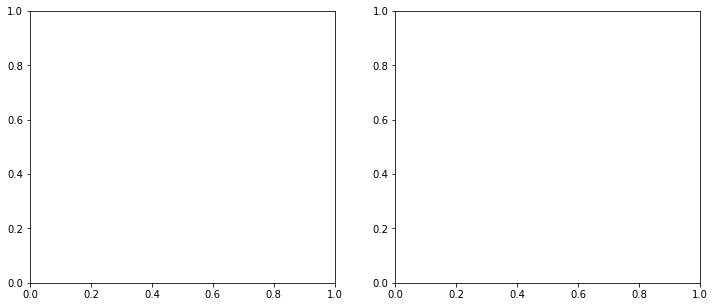

In [34]:
# Matriz de confusión Logistic Regression
cm_logreg = metrics.confusion_matrix(y_eval, y_pred_logreg)
disp_logreg = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_logreg)

# Matriz de confusión Random Forest
cm_rf = metrics.confusion_matrix(y_eval, y_pred_rf)
disp_rf = metrics.ConfusionMatrixDisplay(confusion_matrix=cm_rf)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
disp_logreg.plot(ax=axes[0], colorbar=False)
axes[0].set_title("Regresión Logística")
axes[0].set_xlabel("Predicción")
axes[0].set_ylabel("Valor real")

disp_rf.plot(ax=axes[1], colorbar=False)
axes[1].set_title("Bosque Aleatorio")
axes[1].set_xlabel("Predicción")
axes[1].set_ylabel("Valor real")

plt.tight_layout()
plt.show()